![xarray Logo](http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png "xarray Logo")

# Introduction to Xarray

---

## Overview

This notebook will introduce the basics of gridded, labeled data with Xarray. Since Xarray introduces additional abstractions on top of plain arrays of data, our goal is to show why these abstractions are useful and how they frequently lead to simpler, more robust code.

We'll cover these topics:

1. Create a `DataArray`, one of the core object types in Xarray
1. Understand how to use named coordinates and metadata in a `DataArray`
1. Combine individual `DataArrays` into a `Dataset`, the other core object type in Xarray
1. Subset, slice, and interpolate the data using named coordinates
1. Open netCDF data using XArray
1. Basic subsetting and aggregation of a `Dataset`
1. Brief introduction to plotting with Xarray

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Necessary |  |
| [Intermediate NumPy](https://foundations.projectpythia.org/core/numpy/intermediate-numpy.htmly) | Helpful | Familiarity with indexing and slicing arrays |
| [NumPy Broadcasting](https://foundations.projectpythia.org/core/numpy/numpy-broadcasting.html) | Helpful | Familiar with array arithmetic and broadcasting |
| [Introduction to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Helpful | Familiarity with labeled data |
| [Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Helpful | Familiarity with time formats and the `timedelta` object |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 30 minutes

---

## Imports

Simmilar to `numpy`, `np`; `pandas`, `pd`; you may often encounter `xarray` imported within a shortened namespace as `xr`. `pythia_datasets` provides example data for us to work with.

In [2]:
from datetime import timedelta

import numpy as np
import pandas as pd
import xarray as xr

## Introducing the `DataArray` and `Dataset`

Xarray expands on the capabilities on NumPy arrays, providing a lot of streamlined data manipulation. It is similar in that respect to Pandas, but whereas Pandas excels at working with tabular data, Xarray is focused on N-dimensional arrays of data (i.e. grids). Its interface is based largely on the netCDF data model (variables, attributes, and dimensions), but it goes beyond the traditional netCDF interfaces to provide functionality similar to netCDF-java's [Common Data Model (CDM)](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/common_data_model_overview.html). 

### Creation of a `DataArray` object

The `DataArray` is one of the basic building blocks of Xarray (see docs [here](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray)). It provides a `numpy.ndarray`-like object that expands to provide two critical pieces of functionality:

1. Coordinate names and values are stored with the data, making slicing and indexing much more powerful
2. It has a built-in container for attributes

Here we'll initialize a `DataArray` object by wrapping a plain NumPy array, and explore a few of its properties.

#### Generate a random numpy array

For our first example, we'll just create a random array of "temperature" data in units of Kelvin:

In [3]:
data = 283 + 5 * np.random.randn(5, 3, 4)
data

array([[[294.52311115, 274.17935966, 279.44309904, 288.43385014],
        [274.36666414, 283.98541275, 279.54118365, 287.37133183],
        [267.44618841, 282.36910538, 283.33481019, 277.04074903]],

       [[289.13572806, 278.41677035, 284.92783242, 287.86970347],
        [281.61151817, 284.10180132, 292.08428902, 285.06577257],
        [279.38213692, 290.12350246, 280.80931478, 284.08377865]],

       [[280.11004696, 272.11824925, 281.91598699, 273.56356435],
        [288.64774602, 283.2209609 , 282.62782603, 277.31210444],
        [284.25980474, 287.8752132 , 290.89409864, 295.6697753 ]],

       [[286.0554548 , 278.54019069, 289.22937461, 283.03132268],
        [282.13974325, 286.67047752, 291.873511  , 281.37576291],
        [283.40032695, 281.78845193, 291.29928085, 286.41844878]],

       [[285.14569476, 279.98014773, 291.41769268, 279.77272703],
        [282.52924653, 283.21139521, 281.29817267, 286.43154075],
        [287.24469751, 278.57895038, 274.98691215, 286.79385506]]])

#### Wrap the array: first attempt

Now we create a basic `DataArray` just by passing our plain `data` as input:

In [4]:
temp = xr.DataArray(data)
temp

<xarray.DataArray (dim_0: 5, dim_1: 3, dim_2: 4)>
array([[[294.52311115, 274.17935966, 279.44309904, 288.43385014],
        [274.36666414, 283.98541275, 279.54118365, 287.37133183],
        [267.44618841, 282.36910538, 283.33481019, 277.04074903]],

       [[289.13572806, 278.41677035, 284.92783242, 287.86970347],
        [281.61151817, 284.10180132, 292.08428902, 285.06577257],
        [279.38213692, 290.12350246, 280.80931478, 284.08377865]],

       [[280.11004696, 272.11824925, 281.91598699, 273.56356435],
        [288.64774602, 283.2209609 , 282.62782603, 277.31210444],
        [284.25980474, 287.8752132 , 290.89409864, 295.6697753 ]],

       [[286.0554548 , 278.54019069, 289.22937461, 283.03132268],
        [282.13974325, 286.67047752, 291.873511  , 281.37576291],
        [283.40032695, 281.78845193, 291.29928085, 286.41844878]],

       [[285.14569476, 279.98014773, 291.41769268, 279.77272703],
        [282.52924653, 283.21139521, 281.29817267, 286.43154075],
        [287.24469751, 278.57895038, 274.98691215, 286.79385506]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

Note two things:

1. Xarray generates some basic dimension names for us (`dim_0`, `dim_1`, `dim_2`). We'll improve this with better names in the next example.
2. Wrapping the numpy array in a `DataArray` gives us a rich display in the notebook! (Try clicking the array symbol to expand or collapse the view)

#### Assign dimension names

Much of the power of Xarray comes from making use of named dimensions. So let's add some more useful names! We can do that by passing an ordered list of names using the keyword argument `dims`:

In [5]:
temp = xr.DataArray(data, dims=['time', 'lat', 'lon'])
temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[294.52311115, 274.17935966, 279.44309904, 288.43385014],
        [274.36666414, 283.98541275, 279.54118365, 287.37133183],
        [267.44618841, 282.36910538, 283.33481019, 277.04074903]],

       [[289.13572806, 278.41677035, 284.92783242, 287.86970347],
        [281.61151817, 284.10180132, 292.08428902, 285.06577257],
        [279.38213692, 290.12350246, 280.80931478, 284.08377865]],

       [[280.11004696, 272.11824925, 281.91598699, 273.56356435],
        [288.64774602, 283.2209609 , 282.62782603, 277.31210444],
        [284.25980474, 287.8752132 , 290.89409864, 295.6697753 ]],

       [[286.0554548 , 278.54019069, 289.22937461, 283.03132268],
        [282.13974325, 286.67047752, 291.873511  , 281.37576291],
        [283.40032695, 281.78845193, 291.29928085, 286.41844878]],

       [[285.14569476, 279.98014773, 291.41769268, 279.77272703],
        [282.52924653, 283.21139521, 281.29817267, 286.43154075],
        [287.24469751, 278.57895038, 274.98691215, 286.79385506]]])
Dimensions without coordinates: time, lat, lon

This is already improved upon from a NumPy array, because we have names for each of the dimensions (or axes in NumPy parlance). Even better, we can take arrays representing the values for the coordinates for each of these dimensions and associate them with the data when we create the `DataArray`. We'll see this in the next example.

### Create a `DataArray` with named Coordinates

#### Make time and space coordinates

Here we will use [Pandas](../pandas) to create an array of [datetime data](../datetime), which we will then use to create a `DataArray` with a named coordinate `time`.

In [6]:
times = pd.date_range('2018-01-01', periods=5)
times

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq='D')

We'll also create arrays to represent sample longitude and latitude:

In [7]:
lons = np.linspace(-120, -60, 4)
lats = np.linspace(25, 55, 3)

#### Initialize the `DataArray` with complete coordinate info

When we create the `DataArray` instance, we pass in the arrays we just created:

In [8]:
temp = xr.DataArray(data, coords=[times, lats, lons], dims=['time', 'lat', 'lon'])
temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[294.52311115, 274.17935966, 279.44309904, 288.43385014],
        [274.36666414, 283.98541275, 279.54118365, 287.37133183],
        [267.44618841, 282.36910538, 283.33481019, 277.04074903]],

       [[289.13572806, 278.41677035, 284.92783242, 287.86970347],
        [281.61151817, 284.10180132, 292.08428902, 285.06577257],
        [279.38213692, 290.12350246, 280.80931478, 284.08377865]],

       [[280.11004696, 272.11824925, 281.91598699, 273.56356435],
        [288.64774602, 283.2209609 , 282.62782603, 277.31210444],
        [284.25980474, 287.8752132 , 290.89409864, 295.6697753 ]],

       [[286.0554548 , 278.54019069, 289.22937461, 283.03132268],
        [282.13974325, 286.67047752, 291.873511  , 281.37576291],
        [283.40032695, 281.78845193, 291.29928085, 286.41844878]],

       [[285.14569476, 279.98014773, 291.41769268, 279.77272703],
        [282.52924653, 283.21139521, 281.29817267, 286.43154075],
        [287.24469751, 278.57895038, 274.98691215, 286.79385506]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0

#### Set useful attributes

...and while we're at it, we can also set some attribute metadata:

In [9]:
temp.attrs['units'] = 'kelvin'
temp.attrs['standard_name'] = 'air_temperature'

temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[294.52311115, 274.17935966, 279.44309904, 288.43385014],
        [274.36666414, 283.98541275, 279.54118365, 287.37133183],
        [267.44618841, 282.36910538, 283.33481019, 277.04074903]],

       [[289.13572806, 278.41677035, 284.92783242, 287.86970347],
        [281.61151817, 284.10180132, 292.08428902, 285.06577257],
        [279.38213692, 290.12350246, 280.80931478, 284.08377865]],

       [[280.11004696, 272.11824925, 281.91598699, 273.56356435],
        [288.64774602, 283.2209609 , 282.62782603, 277.31210444],
        [284.25980474, 287.8752132 , 290.89409864, 295.6697753 ]],

       [[286.0554548 , 278.54019069, 289.22937461, 283.03132268],
        [282.13974325, 286.67047752, 291.873511  , 281.37576291],
        [283.40032695, 281.78845193, 291.29928085, 286.41844878]],

       [[285.14569476, 279.98014773, 291.41769268, 279.77272703],
        [282.52924653, 283.21139521, 281.29817267, 286.43154075],
        [287.24469751, 278.57895038, 274.98691215, 286.79385506]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

#### Attributes are not preserved by default!

Notice what happens if we perform a mathematical operaton with the `DataArray`: the coordinate values persist, but the attributes are lost. This is done because it is very challenging to know if the attribute metadata is still correct or appropriate after arbitrary arithmetic operations.

To illustrate this, we'll do a simple unit conversion from Kelvin to Celsius:

In [10]:
temp_in_celsius = temp - 273.15
temp_in_celsius

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[21.37311115,  1.02935966,  6.29309904, 15.28385014],
        [ 1.21666414, 10.83541275,  6.39118365, 14.22133183],
        [-5.70381159,  9.21910538, 10.18481019,  3.89074903]],

       [[15.98572806,  5.26677035, 11.77783242, 14.71970347],
        [ 8.46151817, 10.95180132, 18.93428902, 11.91577257],
        [ 6.23213692, 16.97350246,  7.65931478, 10.93377865]],

       [[ 6.96004696, -1.03175075,  8.76598699,  0.41356435],
        [15.49774602, 10.0709609 ,  9.47782603,  4.16210444],
        [11.10980474, 14.7252132 , 17.74409864, 22.5197753 ]],

       [[12.9054548 ,  5.39019069, 16.07937461,  9.88132268],
        [ 8.98974325, 13.52047752, 18.723511  ,  8.22576291],
        [10.25032695,  8.63845193, 18.14928085, 13.26844878]],

       [[11.99569476,  6.83014773, 18.26769268,  6.62272703],
        [ 9.37924653, 10.06139521,  8.14817267, 13.28154075],
        [14.09469751,  5.42895038,  1.83691215, 13.64385506]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0

For an in-depth discussion of how Xarray handles metadata, start in the Xarray docs [here](http://xarray.pydata.org/en/stable/getting-started-guide/faq.html#approach-to-metadata).

### The `Dataset`: a container for `DataArray`s with shared coordinates

Along with `DataArray`, the other key object type in Xarray is the `Dataset`: a dictionary-like container that holds one or more `DataArray`s, which can also optionally share coordinates (see docs [here](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset)).

The most common way to create a `Dataset` object is to load data from a file (see [below](#Opening-netCDF-data)). Here, instead, we will create another `DataArray` and combine it with our `temp` data.

This will illustrate how the information about common coordinate axes is used.

#### Create a pressure `DataArray` using the same coordinates

This code mirrors how we created the `temp` object above.

In [11]:
pressure_data = 1000.0 + 5 * np.random.randn(5, 3, 4)
pressure = xr.DataArray(
    pressure_data, coords=[times, lats, lons], dims=['time', 'lat', 'lon']
)
pressure.attrs['units'] = 'hPa'
pressure.attrs['standard_name'] = 'air_pressure'

pressure

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[ 995.70086054, 1004.87314243,  996.47829389,  996.84878566],
        [1002.42065902,  999.33296856, 1004.38545524, 1007.85574687],
        [1002.73738839, 1004.84502698,  998.39131555,  997.26232529]],

       [[1005.35252919,  996.12158422,  998.14694452,  998.32422835],
        [1002.06137198,  999.94131893, 1003.69351875, 1002.06448187],
        [1006.36552901,  995.91749536, 1000.42747047,  988.95422539]],

       [[ 998.57154447, 1005.57746015,  994.77432836,  990.97207446],
        [1004.65478763,  997.16027592,  996.55655309, 1000.35446859],
        [ 996.45487406, 1003.19053658,  999.25909263,  993.33753211]],

       [[1008.17422964,  996.22327144, 1001.21598823, 1000.26456639],
        [ 995.1718613 ,  993.87417131,  998.98228343, 1001.76855477],
        [ 996.27892796,  997.55209685,  999.74227687,  995.03140927]],

       [[ 997.46070262, 1004.19682637, 1013.2598496 , 1000.32289156],
        [ 999.27577556,  996.93350209, 1000.73688744,  993.02464585],
        [1000.34911889, 1007.53228997,  993.79203594, 1003.99056356]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

#### Create a `Dataset` object

Each `DataArray` in our `Dataset` needs a name! 

The most straightforward way to create a `Dataset` with our `temp` and `pressure` arrays is to pass a dictionary using the keyword argument `data_vars`:

In [12]:
ds = xr.Dataset(data_vars={'Temperature': temp, 'Pressure': pressure})
ds

<xarray.Dataset>
Dimensions:      (time: 5, lat: 3, lon: 4)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat          (lat) float64 25.0 40.0 55.0
  * lon          (lon) float64 -120.0 -100.0 -80.0 -60.0
Data variables:
    Temperature  (time, lat, lon) float64 294.5 274.2 279.4 ... 275.0 286.8
    Pressure     (time, lat, lon) float64 995.7 1.005e+03 ... 993.8 1.004e+03

Notice that the `Dataset` object `ds` is aware that both data arrays sit on the same coordinate axes.

#### Access Data variables and Coordinates in a `Dataset`

We can pull out any of the individual `DataArray` objects in a few different ways.

Using the "dot" notation:

In [13]:
ds.Pressure

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)>
array([[[ 995.70086054, 1004.87314243,  996.47829389,  996.84878566],
        [1002.42065902,  999.33296856, 1004.38545524, 1007.85574687],
        [1002.73738839, 1004.84502698,  998.39131555,  997.26232529]],

       [[1005.35252919,  996.12158422,  998.14694452,  998.32422835],
        [1002.06137198,  999.94131893, 1003.69351875, 1002.06448187],
        [1006.36552901,  995.91749536, 1000.42747047,  988.95422539]],

       [[ 998.57154447, 1005.57746015,  994.77432836,  990.97207446],
        [1004.65478763,  997.16027592,  996.55655309, 1000.35446859],
        [ 996.45487406, 1003.19053658,  999.25909263,  993.33753211]],

       [[1008.17422964,  996.22327144, 1001.21598823, 1000.26456639],
        [ 995.1718613 ,  993.87417131,  998.98228343, 1001.76855477],
        [ 996.27892796,  997.55209685,  999.74227687,  995.03140927]],

       [[ 997.46070262, 1004.19682637, 1013.2598496 , 1000.32289156],
        [ 999.27577556,  996.93350209, 1000.73688744,  993.02464585],
        [1000.34911889, 1007.53228997,  993.79203594, 1003.99056356]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

... or using dictionary access like this:

In [14]:
ds['Pressure']

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)>
array([[[ 995.70086054, 1004.87314243,  996.47829389,  996.84878566],
        [1002.42065902,  999.33296856, 1004.38545524, 1007.85574687],
        [1002.73738839, 1004.84502698,  998.39131555,  997.26232529]],

       [[1005.35252919,  996.12158422,  998.14694452,  998.32422835],
        [1002.06137198,  999.94131893, 1003.69351875, 1002.06448187],
        [1006.36552901,  995.91749536, 1000.42747047,  988.95422539]],

       [[ 998.57154447, 1005.57746015,  994.77432836,  990.97207446],
        [1004.65478763,  997.16027592,  996.55655309, 1000.35446859],
        [ 996.45487406, 1003.19053658,  999.25909263,  993.33753211]],

       [[1008.17422964,  996.22327144, 1001.21598823, 1000.26456639],
        [ 995.1718613 ,  993.87417131,  998.98228343, 1001.76855477],
        [ 996.27892796,  997.55209685,  999.74227687,  995.03140927]],

       [[ 997.46070262, 1004.19682637, 1013.2598496 , 1000.32289156],
        [ 999.27577556,  996.93350209, 1000.73688744,  993.02464585],
        [1000.34911889, 1007.53228997,  993.79203594, 1003.99056356]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

We'll return to the `Dataset` object when we start loading data from files.

## Subsetting and selection by coordinate values

Much of the power of labeled coordinates comes from the ability to select data based on coordinate names and values, rather than array indices. We'll explore this briefly here.

### NumPy-like selection

Suppose we want to extract all the spatial data for one single date: January 2, 2018. It's possible to achieve that with NumPy-like index selection:

In [15]:
indexed_selection = temp[1, :, :]  # Index 1 along axis 0 is the time slice we want...
indexed_selection

<xarray.DataArray (lat: 3, lon: 4)>
array([[289.13572806, 278.41677035, 284.92783242, 287.86970347],
       [281.61151817, 284.10180132, 292.08428902, 285.06577257],
       [279.38213692, 290.12350246, 280.80931478, 284.08377865]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

HOWEVER, notice that this requires us (the user / programmer) to have **detailed knowledge** of the order of the axes and the meaning of the indices along those axes!

_**Named coordinates free us from this burden...**_

### Selecting with `.sel()`

We can instead select data based on coordinate values using the `.sel()` method, which takes one or more named coordinate(s) as keyword argument:

In [16]:
named_selection = temp.sel(time='2018-01-02')
named_selection

<xarray.DataArray (lat: 3, lon: 4)>
array([[289.13572806, 278.41677035, 284.92783242, 287.86970347],
       [281.61151817, 284.10180132, 292.08428902, 285.06577257],
       [279.38213692, 290.12350246, 280.80931478, 284.08377865]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

We got the same result, but 
- we didn't have to know anything about how the array was created or stored
- our code is agnostic about how many dimensions we are dealing with
- the intended meaning of our code is much clearer!

### Approximate selection and interpolation

With time and space data, we frequently want to sample "near" the coordinate points in our dataset. Here are a few simple ways to achieve that.

#### Nearest-neighbor sampling

Suppose we want to sample the nearest datapoint within 2 days of date `2018-01-07`. Since the last day on our `time` axis is `2018-01-05`, this is well-posed.

`.sel` has the flexibility to perform nearest neighbor sampling, taking an optional tolerance:

In [17]:
temp.sel(time='2018-01-07', method='nearest', tolerance=timedelta(days=2))

<xarray.DataArray (lat: 3, lon: 4)>
array([[285.14569476, 279.98014773, 291.41769268, 279.77272703],
       [282.52924653, 283.21139521, 281.29817267, 286.43154075],
       [287.24469751, 278.57895038, 274.98691215, 286.79385506]])
Coordinates:
    time     datetime64[ns] 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

where we see that `.sel` indeed pulled out the data for date `2018-01-05`.

#### Interpolation

Suppose we want to extract a timeseries for Boulder (40°N, 105°W). Since `lon=-105` is _not_ a point on our longitude axis, this requires interpolation between data points.

The `.interp()` method (see the docs [here](http://xarray.pydata.org/en/stable/interpolation.html)) works similarly to `.sel()`. Using `.interp()`, we can interpolate to any latitude/longitude location:

In [18]:
temp.interp(lon=-105, lat=40)

<xarray.DataArray (time: 5)>
array([281.5807256 , 283.47923053, 284.57765718, 285.53779395,
       283.04085804])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
    lon      int64 -105
    lat      int64 40
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Xarray's interpolation functionality requires the <a href="https://scipy.org/">SciPy</a> package!
</div>

### Slicing along coordinates

Frequently we want to select a range (or _slice_) along one or more coordinate(s). We can achieve this by passing a Python [slice](https://docs.python.org/3/library/functions.html#slice) object to `.sel()`, as follows:

In [19]:
temp.sel(
    time=slice('2018-01-01', '2018-01-03'), lon=slice(-110, -70), lat=slice(25, 45)
)

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[274.17935966, 279.44309904],
        [283.98541275, 279.54118365]],

       [[278.41677035, 284.92783242],
        [284.10180132, 292.08428902]],

       [[272.11824925, 281.91598699],
        [283.2209609 , 282.62782603]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    The calling sequence for <code>slice</code> always looks like <code>slice(start, stop[, step])</code>, where <code>step</code> is optional.
</div>

Notice how the length of each coordinate axis has changed due to our slicing.

### One more selection method: `.loc`

All of these operations can also be done within square brackets on the `.loc` attribute of the `DataArray`:


In [20]:
temp.loc['2018-01-02']

<xarray.DataArray (lat: 3, lon: 4)>
array([[289.13572806, 278.41677035, 284.92783242, 287.86970347],
       [281.61151817, 284.10180132, 292.08428902, 285.06577257],
       [279.38213692, 290.12350246, 280.80931478, 284.08377865]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This is sort of in between the NumPy-style selection
```
temp[1,:,:]
```
and the fully label-based selection using `.sel()`

With `.loc`, we make use of the coordinate *values*, but lose the ability to specify the *names* of the various dimensions. Instead, the slicing must be done in the correct order:

In [21]:
temp.loc['2018-01-01':'2018-01-03', 25:45, -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[274.17935966, 279.44309904],
        [283.98541275, 279.54118365]],

       [[278.41677035, 284.92783242],
        [284.10180132, 292.08428902]],

       [[272.11824925, 281.91598699],
        [283.2209609 , 282.62782603]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

One advantage of using `.loc` is that we can use NumPy-style slice notation like `25:45`, rather than the more verbose `slice(25,45)`. But of course that also works:

In [22]:
temp.loc['2018-01-01':'2018-01-03', slice(25, 45), -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[274.17935966, 279.44309904],
        [283.98541275, 279.54118365]],

       [[278.41677035, 284.92783242],
        [284.10180132, 292.08428902]],

       [[272.11824925, 281.91598699],
        [283.2209609 , 282.62782603]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

What *doesn't* work is passing the slices in a different order:

In [ ]:
# This will generate an error
# temp.loc[-110:-70, 25:45,'2018-01-01':'2018-01-03']

## Opening netCDF data

With its close ties to the netCDF data model, Xarray also supports netCDF as a first-class file format. This means it has easy support for opening netCDF datasets, so long as they conform to some of Xarray's limitations (such as 1-dimensional coordinates).

### Access netCDF data with `xr.open_dataset`

In [23]:
filepath = 'data/NARR_19930313_0000.nc'

Once we have a valid path to a data file that Xarray knows how to read, we can open it like this:

In [24]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:                       (time1: 1, isobaric1: 29, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 1993-03-13
  * isobaric1                     (isobaric1) float32 100.0 125.0 ... 1e+03
  * y                             (y) float32 -3.117e+03 -3.084e+03 ... 714.1
  * x                             (x) float32 -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 ...
    lon                           (y, x) float64 ...
    Geopotential_height_isobaric  (time1, isobaric1, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    Temperature_isobaric          (time1, isobaric1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

### Subsetting the `Dataset`

Our call to `xr.open_dataset()` above returned a `Dataset` object that we've decided to call `ds`. We can then pull out individual fields:

In [25]:
ds.isobaric1

<xarray.DataArray 'isobaric1' (isobaric1: 29)>
array([ 100.,  125.,  150.,  175.,  200.,  225.,  250.,  275.,  300.,  350.,
        400.,  450.,  500.,  550.,  600.,  650.,  700.,  725.,  750.,  775.,
        800.,  825.,  850.,  875.,  900.,  925.,  950.,  975., 1000.],
      dtype=float32)
Coordinates:
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
Attributes:
    units:                   hPa
    long_name:               Isobaric surface
    positive:                down
    Grib_level_type:         100
    _CoordinateAxisType:     Pressure
    _CoordinateZisPositive:  down

(recall that we can also use dictionary syntax like `ds['isobaric1']` to do the same thing)

`Dataset`s also support much of the same subsetting operations as `DataArray`, but will perform the operation on all data:

In [26]:
ds_1000 = ds.sel(isobaric1=1000.0)
ds_1000

<xarray.Dataset>
Dimensions:                       (time1: 1, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 1993-03-13
    isobaric1                     float32 1e+03
  * y                             (y) float32 -3.117e+03 -3.084e+03 ... 714.1
  * x                             (x) float32 -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, y, x) float32 ...
    LambertConformal_Projection   int32 0
    lat                           (y, x) float64 17.87 17.96 ... 34.85 34.64
    lon                           (y, x) float64 -135.0 -134.8 ... -43.13 -42.91
    Geopotential_height_isobaric  (time1, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, y, x) float32 ...
    Temperature_isobaric          (time1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

And further subsetting to a single `DataArray`:

In [27]:
ds_1000.Temperature_isobaric

<xarray.DataArray 'Temperature_isobaric' (time1: 1, y: 119, x: 268)>
array([[[294.09436, 294.1256 , ..., 298.6725 , 298.71936],
        [294.07874, 294.14124, ..., 298.6256 , 298.5475 ],
        ...,
        [276.86   , 276.84436, ..., 289.11   , 289.01624],
        [277.01624, 276.82874, ..., 289.0475 , 288.96936]]], dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
    isobaric1  float32 1e+03
  * y          (y) float32 -3.117e+03 -3.084e+03 -3.052e+03 ... 681.6 714.1
  * x          (x) float32 -3.324e+03 -3.292e+03 ... 5.311e+03 5.343e+03
Attributes:
    long_name:           Temperature @ Isobaric surface
    units:               K
    description:         Temperature
    grid_mapping:        LambertConformal_Projection
    Grib_Variable_Id:    VAR_7-15-131-11_L100
    Grib1_Center:        7
    Grib1_Subcenter:     15
    Grib1_TableVersion:  131
    Grib1_Parameter:     11
    Grib1_Level_Type:    100
    Grib1_Level_Desc:    Isobaric surface

### Aggregation operations

Not only can you use the named dimensions for manual slicing and indexing of data, but you can also use it to control aggregation operations, like `std` (standard deviation):

In [28]:
u_winds = ds['u-component_of_wind_isobaric']
u_winds.std(dim=['x', 'y'])

<xarray.DataArray 'u-component_of_wind_isobaric' (time1: 1, isobaric1: 29)>
array([[ 8.673963 , 10.212325 , 11.556413 , 12.254429 , 13.372146 ,
        15.472462 , 16.091969 , 15.846294 , 15.195834 , 13.936979 ,
        12.93888  , 12.060708 , 10.972139 ,  9.722328 ,  8.853286 ,
         8.257241 ,  7.679721 ,  7.4516497,  7.2352104,  7.039894 ,
         6.883371 ,  6.7821493,  6.7088237,  6.6865997,  6.7247376,
         6.745023 ,  6.6859775,  6.5107226,  5.972262 ]], dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Aggregation methods for Xarray objects operate over the named coordinate dimension(s) specified by keyword argument <code>dim</code>. Compare to NumPy, where aggregations operate over specified numbered <code>axes</code>.
</div>

Using the sample dataset, we can calculate the mean temperature profile (temperature as a function of pressure) over Colorado within this dataset. For this exercise, consider the bounds of Colorado to be:
 * x: -182km to 424km
 * y: -1450km to -990km
    
(37°N to 41°N and 102°W to 109°W projected to Lambert Conformal projection coordinates)

In [29]:
temps = ds.Temperature_isobaric
co_temps = temps.sel(x=slice(-182, 424), y=slice(-1450, -990))
prof = co_temps.mean(dim=['x', 'y'])
prof

<xarray.DataArray 'Temperature_isobaric' (time1: 1, isobaric1: 29)>
array([[215.078  , 215.76935, 217.243  , 217.82663, 215.83487, 216.10933,
        219.99902, 224.66118, 228.80576, 234.88701, 238.78503, 242.66309,
        246.44807, 249.26636, 250.84995, 253.37354, 257.0429 , 259.08398,
        260.97955, 262.98364, 264.82138, 266.5198 , 268.22467, 269.7471 ,
        271.18216, 272.66815, 274.13037, 275.54718, 276.97675]],
      dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03

## Plotting with Xarray

Another major benefit of using labeled data structures is that they enable automated plotting with sensible axis labels. 

### Simple visualization with `.plot()`

Much like we saw in [Pandas](../pandas/pandas), Xarray includes an interface to [Matplotlib](../matplotlib) that we can access through the `.plot()` method of every `DataArray`.

For quick and easy data exploration, we can just call `.plot()` without any modifiers:

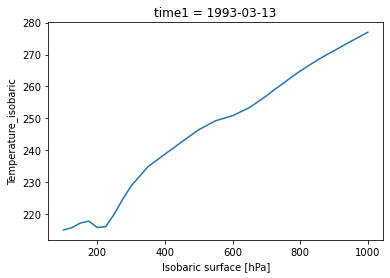

In [30]:
prof.plot()

Here Xarray has generated a line plot of the temperature data against the coordinate variable `isobaric`. Also the metadata are used to auto-generate axis labels and units.

### Customizing the plot

As in Pandas, the `.plot()` method is mostly just a wrapper to Matplotlib, so we can customize our plot in familiar ways.

In this air temperature profile example, we would like to make two changes:
- swap the axes so that we have isobaric levels on the y (vertical) axis of the figure
- make pressure decrease upward in the figure, so that up is up

A few keyword arguments to our `.plot()` call will take care of this:

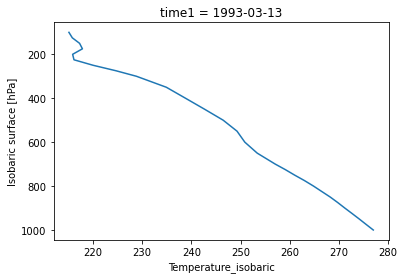

In [31]:
prof.plot(y="isobaric1", yincrease=False)

### Plotting 2D data

In the example above, the `.plot()` method produced a line plot.

What if we call `.plot()` on a 2D array?

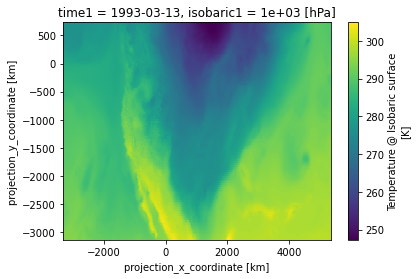

In [32]:
temps.sel(isobaric1=1000).plot()

Xarray has recognized that the `DataArray` object calling the plot method has two coordinate variables, and generates a 2D plot using the `pcolormesh` method from Matplotlib.

In this case, we are looking at air temperatures on the 1000 hPa isobaric surface over North America. We could of course improve this figure by using [Cartopy](../cartopy) to handle the map projection and geographic features!

---

## Summary

Xarray brings the joy of Pandas-style labeled data operations to N-dimensional data. As such, it has become a central workhorse in the geoscience community for the analysis of gridded datasets. Xarray allows us to open self-describing NetCDF files and make full use of the coordinate axes, labels, units, and other metadata. By making use of labeled coordinates, our code is often easier to write, easier to read, and more robust.

### What's next?

Additional notebooks to appear in this section will go into more detail about 
- arithemtic and broadcasting with Xarray data structures
- using "group by" operations
- remote data access with OpenDAP
- more advanced visualization including map integration with Cartopy

## Resources and references

This notebook was adapated from material in [Unidata's Python Training](https://unidata.github.io/python-training/workshop/XArray/xarray-and-cf/).

The best resource for Xarray is the [Xarray documentation](http://xarray.pydata.org/en/stable/). See in particular
- [Why Xarray](http://xarray.pydata.org/en/stable/getting-started-guide/why-xarray.html)
- [Quick overview](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#)
- [Example gallery](http://xarray.pydata.org/en/stable/gallery.html)

Another excellent resource is this [Xarray Tutorial collection](https://xarray-contrib.github.io/xarray-tutorial/).